## Data Preprocessing

In [1]:
import os
import time
from glob import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim

torch.set_printoptions(precision=5)

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid


In [2]:
# check if machine has gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on",device)

Running on cuda:0


In [3]:
# data path that training set is located
path = "../data/fruits/fruits-360/"
# this joins the path + folder and each files e.g. '../data/fruits/fruits-360/Training/Apple Braeburn/115_100.jpg'
files_training = glob(os.path.join(path,'Training', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)

Number of images in Training file: 67692


In [4]:
# just to see how many images we have for each label, minimum one and average one, with nice printing style

min_images = 1000
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(path, 'Training')):
    folder_num = len(os.listdir(os.path.join(path,'Training',folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
        
num_classes = len(class_names)
print("\nMinumum images per category:", np.min(im_cnt), 'Category:', class_names[im_cnt.index(np.min(im_cnt))])    
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

class             Count:
------------------------
Apple Braeburn       492
Apple Crimson Snow   444
Apple Golden 1       480
Apple Golden 2       492
Apple Golden 3       481
Apple Granny Smith   492
Apple Pink Lady      456
Apple Red 1          492
Apple Red 2          492
Apple Red 3          429
Apple Red Delicious  490
Apple Red Yellow 1   492
Apple Red Yellow 2   672
Apricot              492
Avocado              427
Avocado ripe         491
Banana               490
Banana Lady Finger   450
Beetroot             450
Blueberry            462
Cactus fruit         490
Cantaloupe 1         492
Cantaloupe 2         492
Carambula            490
Cauliflower          702
Cherry 1             492
Cherry 2             738
Cherry Rainier       738
Cherry Wax Black     492
Cherry Wax Red       492
Cherry Wax Yellow    492
Chestnut             450
Clementine           490
Cocos                490
Corn                 450
Corn Husk            462
Cucumber Ripe 2      468
Dates                490


In [5]:
# Just to guess pop_mean and pop_std

tensor_transform = transforms.Compose([transforms.ToTensor()])

training_data = ImageFolder(os.path.join(path, 'Training'), tensor_transform)

data_loader = torch.utils.data.DataLoader(training_data, batch_size=512, shuffle=True)

In [6]:
%time
# this part takes a bit long
pop_mean = [0.6840367,0.5786325,0.5037564]  # normally it was --> []
pop_std = [0.30334985,0.3599262,0.3913685]

# for i, data in tqdm(enumerate(data_loader, 0)):
#     numpy_image = data[0].numpy()
    
#     batch_mean = np.mean(numpy_image, axis=(0,2,3))
#     batch_std = np.std(numpy_image, axis=(0,2,3))
    
#     pop_mean.append(batch_mean)
#     pop_std.append(batch_std)

# pop_mean = np.array(pop_mean).mean(axis=0)
# pop_std = np.array(pop_std).mean(axis=0)

# that is why I am inserting last values 

print(pop_mean)
print(pop_std)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.78 µs
[0.6840367, 0.5786325, 0.5037564]
[0.30334985, 0.3599262, 0.3913685]


In [7]:
np.random.seed(123)
shuffle = np.random.permutation(num_images)

In [8]:
# split validation images

split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number images in validation set:',len(shuffle[:split_val]))
print('Number images in train set:',len(shuffle[split_val:]))

Total number of images: 67692
Number images in validation set: 13538
Number images in train set: 54154


In [9]:
class FruitTrainDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

class FruitValidDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y
    
class FruitTestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.data = np.array(glob(os.path.join(path, '*/*.jpg')))
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ])
}

train_dataset = FruitTrainDataset(files_training, shuffle, split_val, class_names, data_transforms['train'])
valid_dataset = FruitValidDataset(files_training, shuffle, split_val, class_names, data_transforms['valid'])
test_dataset = FruitTestDataset("../data/fruits/fruits-360/Test", class_names, transform=data_transforms['Test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [11]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

## Network

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # initialize the parent class methods
        
        self.conv1 = nn.Conv2d(3, 10, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(10, 24, kernel_size = 5, stride = 5)
        self.conv3 = nn.Conv2d(24, 128, kernel_size = 5, stride = 1)
        
        self.pool1 = nn.MaxPool2d(4, stride = 1)
        self.pool2 = nn.MaxPool2d(4, stride = 1)
        
        self.pool3 = nn.AvgPool2d(kernel_size = 5, stride = 5, padding = 0)
        
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 131)
        
    def forward(self, x):   
        in_size = x.size(0)
        
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = F.relu(self.pool3(self.conv3(x)))
        
        x = x.view(in_size, -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 24, kernel_size=(5, 5), stride=(5, 5))
  (conv3): Conv2d(24, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool3): AvgPool2d(kernel_size=5, stride=5, padding=0)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=131, bias=True)
)


## Visualizing Models

In [13]:
import hiddenlayer as hl

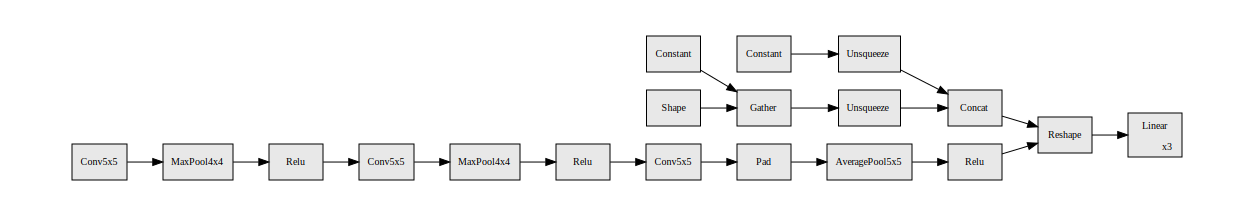

In [14]:
inputs, classes = next(iter(train_loader))
hl.build_graph(net, inputs)

In [15]:
# move network to GPU
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.7)

## Model Analysis Part

In [16]:
# A History object to store metrics
history1 = hl.History()

# A Canvas object to draw the metrics
canvas1 = hl.Canvas()

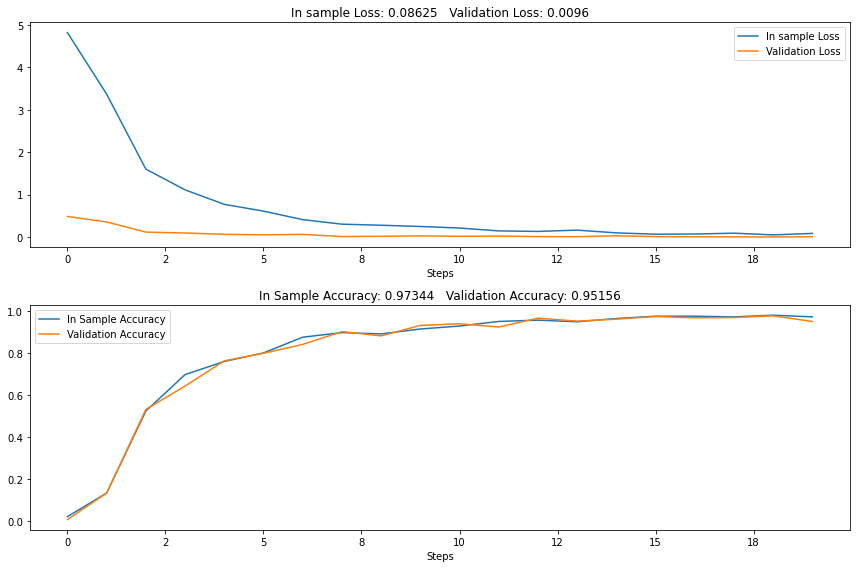


Finished Training


In [17]:
%%time
# let's train the network
def train(net):
    with open("../data/model_5.log", "a") as f:
        for epoch in tqdm(range(20)):
            print("epoch {}".format(epoch))
            running_loss = 0.0
            correct = 0
            total = 0

            val_loss = 0.0
            val_cor = 0
            val_tot = 0

            for i,data in enumerate(train_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)

                # in sample accuracy calculation
                _, predicted = torch.max(outputs, 1) 
                a = predicted == labels
                correct += np.count_nonzero(a.cpu())
                total += len(a)
                
                # validaion accuracy calculation
                val_data = next(iter(valid_loader))
                val_inputs, val_labels = val_data[0].to(device), val_data[1].to(device)
                val_outputs = net(val_inputs)
                _, val_predicted = torch.max(val_outputs, 1) 
                b = val_predicted == val_labels
                val_cor += np.count_nonzero(b.cpu())
                val_tot += len(b)
                
                #print("Validation accuracy",val_cor/val_tot)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                
                val_loss = criterion(val_outputs, val_labels)
                val_loss += val_loss.item()

                if i % 20 == 19 :    # print every 50 mini-batches                  

                    #print('[%d, %5d] loss: %.3f, in sample accuracy: %.3f, val_loss: %.3f, val accuracy : %.3f' %(epoch, i + 1, running_loss / 5, correct/total,
                    #                                                       val_loss / 5, val_cor/val_tot))
                    
                    f.write(f"{float(epoch)},{float(correct/total)},{float(running_loss / 20)},{float(val_cor/val_tot)},{float(val_loss / 20)}\n")
                    
                    # Store metrics in the history object
                    history1.log(epoch, in_loss=round(float(running_loss/20),5), accuracy=round(correct/total,5),
                                 v_loss=round(float(val_loss/20),5),val_accuracy=round(val_cor/val_tot,5)) 

                    with canvas1:
                        canvas1.draw_plot([history1["in_loss"], history1["v_loss"]],
                              labels=["In sample Loss", "Validation Loss"])
                        canvas1.draw_plot([history1["accuracy"], history1["val_accuracy"]],
                              labels=["In Sample Accuracy", "Validation Accuracy"])

                    time.sleep(0.1)
                    
                    running_loss = 0.0
                    correct = 0
                    total = 0

                    val_loss = 0.0
                    val_cor = 0
                    val_tot = 0                   

        print('Finished Training')
    
train(net)

In [18]:
model_data = pd.read_csv("../data/model_5.log",names = ["epochs","accuracy","loss","validation_accuracy","validation_loss"])
model_data.head()

,epochs,accuracy,loss,validation_accuracy,validation_loss
0,0.0,0.004687,4.884789,0.003125,0.487388
1,0.0,0.003125,4.873456,0.004687,0.489720
2,0.0,0.004687,4.878329,0.000000,0.486185
3,0.0,0.006250,4.878206,0.003125,0.486355
4,0.0,0.009375,4.872888,0.010937,0.487558


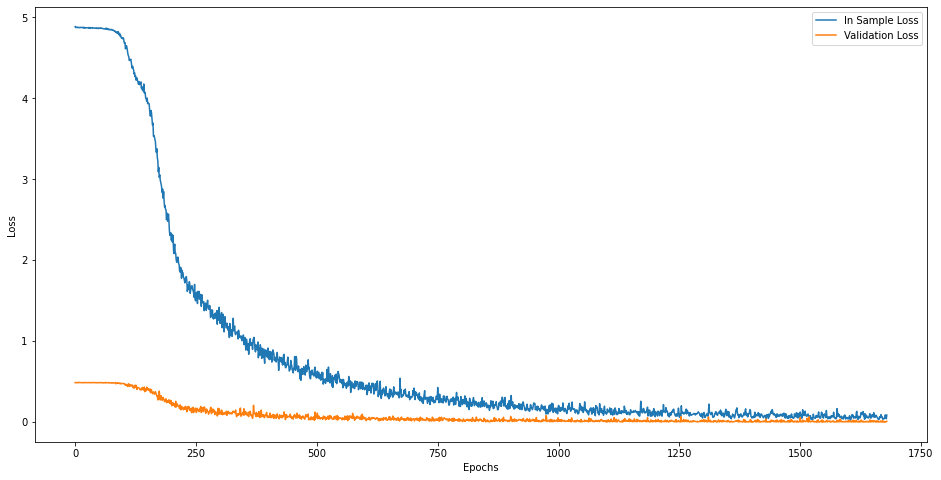

In [19]:
fig, ax = plt.subplots(figsize = (16,8))
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(model_data["loss"], label = "In Sample Loss")
ax.plot(model_data["validation_loss"], label = "Validation Loss")
leg = ax.legend()

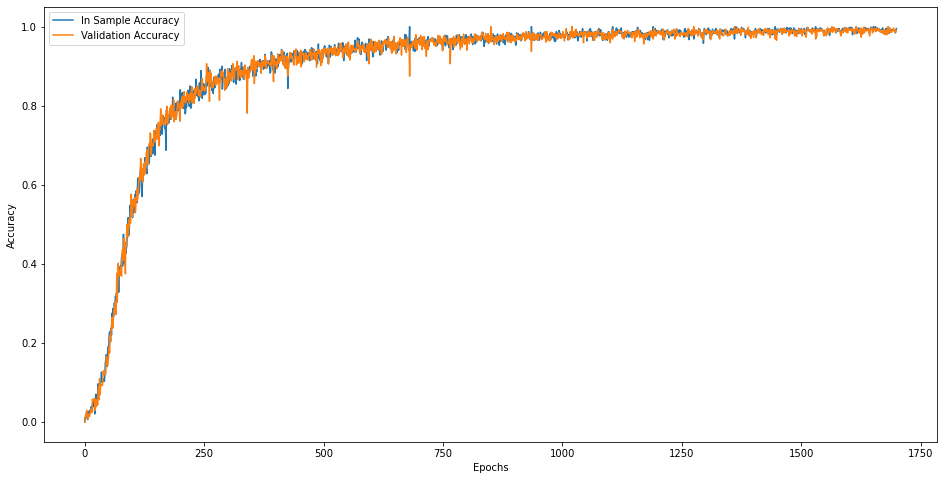

In [29]:
fig, ax = plt.subplots(figsize = (16,8))
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.plot(model_data["accuracy"], label = "In Sample Accuracy")
ax.plot(model_data["validation_accuracy"], label = "Validation Accuracy")
leg = ax.legend()

In [21]:
def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

test(net)


Accuracy of the network on the test images: 90 %


In [23]:
# label wise accuracy
class_correct = list(0. for i in range(131))
class_total = list(0. for i in range(131))
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(131):
    print('Accuracy of %5s : %2d %%' % (
    class_names[i], 100 * class_correct[i] / class_total[i]))


Accuracy of Apple Braeburn : 58 %
Accuracy of Apple Crimson Snow : 43 %
Accuracy of Apple Golden 1 : 100 %
Accuracy of Apple Golden 2 : 100 %
Accuracy of Apple Golden 3 : 83 %
Accuracy of Apple Granny Smith : 99 %
Accuracy of Apple Pink Lady : 92 %
Accuracy of Apple Red 1 : 87 %
Accuracy of Apple Red 2 : 100 %
Accuracy of Apple Red 3 : 90 %
Accuracy of Apple Red Delicious : 92 %
Accuracy of Apple Red Yellow 1 : 85 %
Accuracy of Apple Red Yellow 2 : 98 %
Accuracy of Apricot : 100 %
Accuracy of Avocado : 100 %
Accuracy of Avocado ripe : 100 %
Accuracy of Banana : 95 %
Accuracy of Banana Lady Finger : 100 %
Accuracy of Beetroot : 54 %
Accuracy of Blueberry : 61 %
Accuracy of Cactus fruit : 65 %
Accuracy of Cantaloupe 1 : 100 %
Accuracy of Cantaloupe 2 : 100 %
Accuracy of Carambula : 81 %
Accuracy of Cauliflower : 100 %
Accuracy of Cherry 1 : 100 %
Accuracy of Cherry 2 : 97 %
Accuracy of Cherry Rainier : 76 %
Accuracy of Cherry Wax Black : 100 %
Accuracy of Cherry Wax Red : 100 %
Accuracy

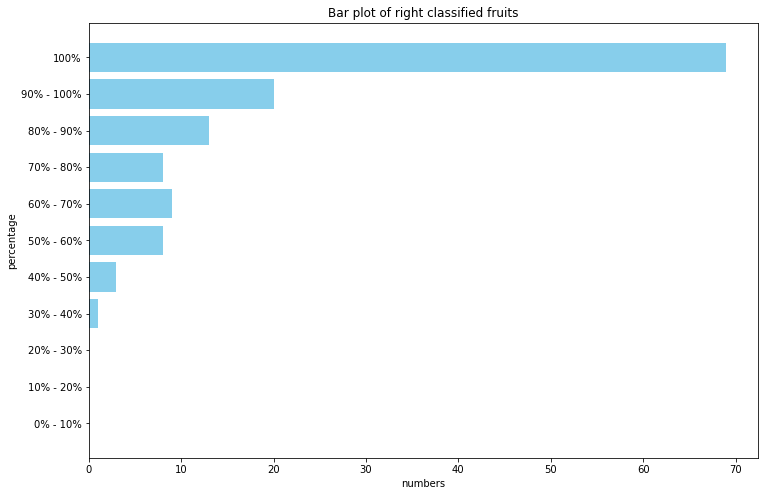

In [27]:
height = [(100 * class_correct[i] / class_total[i]) for i in range(131)]
count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
labels = ["0% - 10%", "10% - 20%", "20% - 30%", "30% - 40%", "40% - 50%", "50% - 60%", "60% - 70%", "70% - 80%", "80% - 90%", "90% - 100%", "100%"]

for i in range(131):
    group = height[i] /10
    count[int(group)] += 1

    y_pos = np.arange(len(labels))

plt.figure(figsize=(12,8))
plt.barh(y_pos, count, color = "skyblue")
plt.title('Bar plot of right classified fruits')
plt.xlabel('numbers')
plt.ylabel('percentage')
plt.yticks(y_pos, labels)
plt.show()

In [28]:
# fnn_net is the first model
# second one is different arch.
# third one is the batch size is 32 instead of 64

PATH = "../models/fnn_net_5.pth"
torch.save(net.state_dict(),PATH)